In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import shap
from pathlib import Path

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for sns bug
import warnings

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*use_inf_as_na option is deprecated.*"
)

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intern-test-data/omics_drug_response_data.xltx


In [4]:
df = pd.read_excel('/kaggle/input/intern-test-data/omics_drug_response_data.xltx')
df.head()

,CELL_LINE_NAME,MT-CO2,MT-CO3,MT-CO1,MT-ND4,MT-ATP8,IGKC,MT-RNR2,MT-ATP6,MT-ND4L,...,PFN1,IGLV3-19,DRUG_ID,DRUG_NAME,TCGA_DESC,DRUG_ID.1,MIN_CONC,MAX_CONC,LN_IC50,AUC
0,42-MG-BA,8435.0,3815.0,2034.0,4559.0,6921.0,2.0,2523.0,6144.0,2765.0,...,407.0,0.0,133,Doxorubicin,GBM,133,0.004000,1.0240,-1.117506,0.743977
1,42-MG-BA,8435.0,3815.0,2034.0,4559.0,6921.0,2.0,2523.0,6144.0,2765.0,...,407.0,0.0,1007,Docetaxel,GBM,1007,0.000049,0.0125,-6.773549,0.559889
2,42-MG-BA,8435.0,3815.0,2034.0,4559.0,6921.0,2.0,2523.0,6144.0,2765.0,...,407.0,0.0,1386,Doxorubicin,GBM,1386,0.019531,5.0000,-3.141512,0.211750
3,5637,7006.0,6578.0,4596.0,4175.0,3385.0,0.2,1624.0,3710.0,2435.0,...,286.0,0.0,133,Doxorubicin,BLCA,133,0.004000,1.0240,-3.794343,0.328568
4,5637,7006.0,6578.0,4596.0,4175.0,3385.0,0.2,1624.0,3710.0,2435.0,...,286.0,0.0,1007,Docetaxel,BLCA,1007,0.000049,0.0125,-8.391052,0.298870


In [5]:
# 1. Prétraitement des données
# 1. Check if DRUG_ID and DRUG_ID.1 are the same for all rows
same_drug_id = (df['DRUG_ID'] == df['DRUG_ID.1']).all()
print("Are DRUG_ID and DRUG_ID.1 identical for all rows?", same_drug_id)

if same_drug_id : 
    df_clean = df.drop(columns=['DRUG_ID.1'])
    print("\nDRUG_ID.1 is droped")



# check if there are any missing values at all
any_missing = df.isnull().values.any()
print("\nAre there any missing values in the dataset?", any_missing)

# 3. Check for each CELL_LINE_NAME if the columns MT-CO2 up to IGLV3-19 stay the same
# Find the column range
start_col = 'MT-CO2'
end_col = 'IGLV3-19'
columns_of_interest = df.loc[:, start_col:end_col].columns

# Group by CELL_LINE_NAME and check if all rows are identical within each group
b = df.groupby('CELL_LINE_NAME')[columns_of_interest].nunique()

# If a cell line has unique values >1 in any column, then it's inconsistent
inconsistent_cells = b[b.max(axis=1) > 1]

if inconsistent_cells.empty:
    print("\nFor each CELL_LINE_NAME, the gene expression columns are consistent.")
else:
    print("\nInconsistent CELL_LINE_NAME(s) found:")
    print(inconsistent_cells)


Are DRUG_ID and DRUG_ID.1 identical for all rows? True

DRUG_ID.1 is droped

Are there any missing values in the dataset? False

For each CELL_LINE_NAME, the gene expression columns are consistent.


In [6]:
df_clean.head()

,CELL_LINE_NAME,MT-CO2,MT-CO3,MT-CO1,MT-ND4,MT-ATP8,IGKC,MT-RNR2,MT-ATP6,MT-ND4L,...,NQO1,PFN1,IGLV3-19,DRUG_ID,DRUG_NAME,TCGA_DESC,MIN_CONC,MAX_CONC,LN_IC50,AUC
0,42-MG-BA,8435.0,3815.0,2034.0,4559.0,6921.0,2.0,2523.0,6144.0,2765.0,...,132.0,407.0,0.0,133,Doxorubicin,GBM,0.004000,1.0240,-1.117506,0.743977
1,42-MG-BA,8435.0,3815.0,2034.0,4559.0,6921.0,2.0,2523.0,6144.0,2765.0,...,132.0,407.0,0.0,1007,Docetaxel,GBM,0.000049,0.0125,-6.773549,0.559889
2,42-MG-BA,8435.0,3815.0,2034.0,4559.0,6921.0,2.0,2523.0,6144.0,2765.0,...,132.0,407.0,0.0,1386,Doxorubicin,GBM,0.019531,5.0000,-3.141512,0.211750
3,5637,7006.0,6578.0,4596.0,4175.0,3385.0,0.2,1624.0,3710.0,2435.0,...,48.0,286.0,0.0,133,Doxorubicin,BLCA,0.004000,1.0240,-3.794343,0.328568
4,5637,7006.0,6578.0,4596.0,4175.0,3385.0,0.2,1624.0,3710.0,2435.0,...,48.0,286.0,0.0,1007,Docetaxel,BLCA,0.000049,0.0125,-8.391052,0.298870


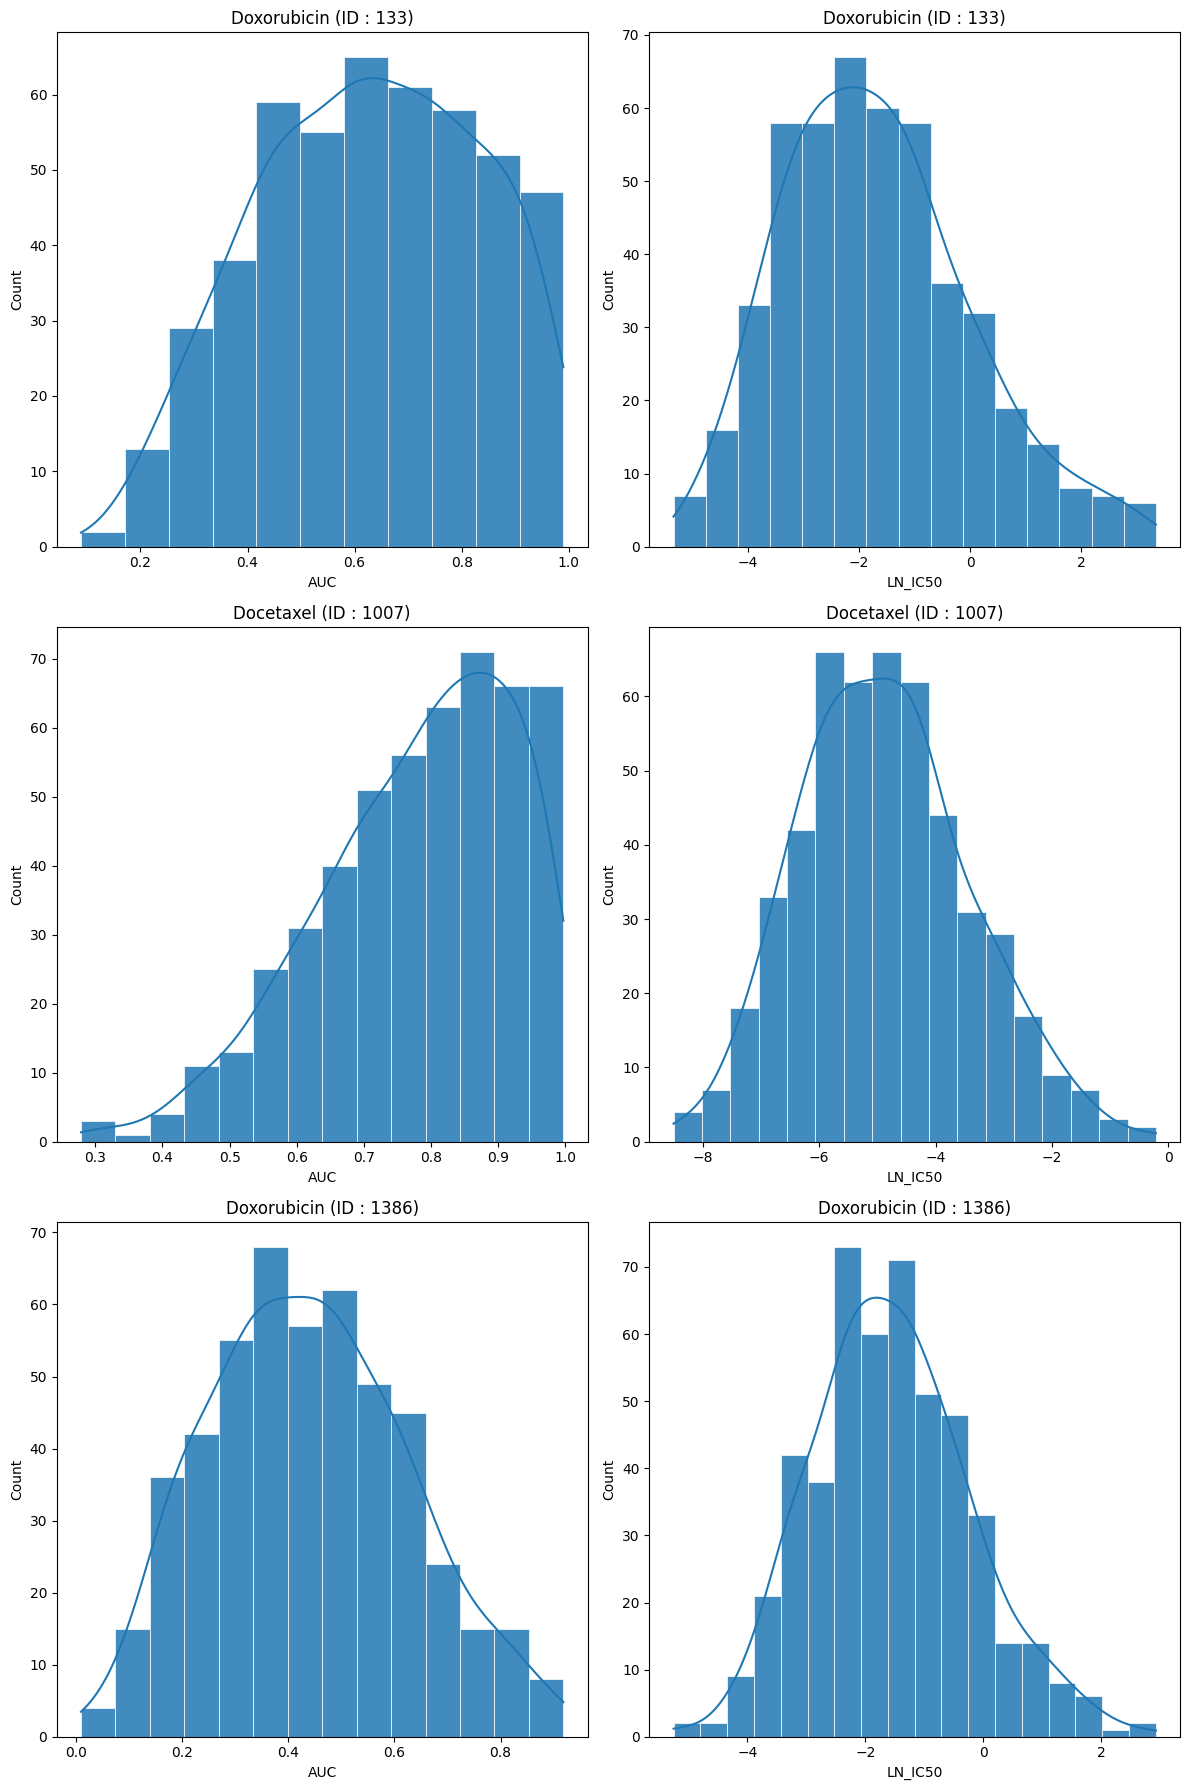

In [7]:
# 2. Analyse exploratoire
unique_drugs = df[['DRUG_ID', 'DRUG_NAME']].drop_duplicates().reset_index(drop=True)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))

for i, (_, row) in enumerate(unique_drugs.iterrows()):
    drug_id   = row['DRUG_ID']
    drug_name = row['DRUG_NAME']
    subset    = df[df['DRUG_ID'] == drug_id]

    # ---------- AUC distribution (left column) ----------
    ax_auc = axes[i, 0]
    sns.histplot(
        subset['AUC'],
        kde=True,
        ax=ax_auc,
        edgecolor='white',
        linewidth=0.5,
        alpha=0.85
    )
    ax_auc.set_title(f'{drug_name} (ID : {drug_id})')
    ax_auc.set_xlabel('AUC')
    ax_auc.set_ylabel('Count')

    # ---------- LN_IC50 distribution (right column) ----------
    ax_ic50 = axes[i, 1]
    sns.histplot(
        subset['LN_IC50'],
        kde=True,
        ax=ax_ic50,
        edgecolor='white',
        linewidth=0.5,
        alpha=0.85
    )
    ax_ic50.set_title(f'{drug_name} (ID : {drug_id})')
    ax_ic50.set_xlabel('LN_IC50')
    ax_ic50.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [8]:
# 3. Modélisation (Régression)
# Create one-hot encoded columns for DRUG_ID
dummies = pd.get_dummies(df['DRUG_ID'], prefix='DRUG')
dummies.head()

,DRUG_133,DRUG_1007,DRUG_1386
0,True,False,False
1,False,True,False
2,False,False,True
3,True,False,False
4,False,True,False


In [10]:
# 3. Concatenate the dummies to the original DataFrame
df_training = pd.concat([df_clean, dummies], axis=1)

# 4. Reorder columns: move the new one-hot columns just after 'IGLV3-19'
cols = list(df_training.columns)
insert_idx = cols.index('IGLV3-19') + 1
for col in dummies.columns:
    cols.insert(insert_idx, cols.pop(cols.index(col)))
    insert_idx += 1

df_training = df_training[cols]

In [11]:
df_training

,CELL_LINE_NAME,MT-CO2,MT-CO3,MT-CO1,MT-ND4,MT-ATP8,IGKC,MT-RNR2,MT-ATP6,MT-ND4L,...,DRUG_133,DRUG_1007,DRUG_1386,DRUG_ID,DRUG_NAME,TCGA_DESC,MIN_CONC,MAX_CONC,LN_IC50,AUC
0,42-MG-BA,8435.0,3815.0,2034.0,4559.0,6921.0,2.0,2523.0,6144.0,2765.0,...,True,False,False,133,Doxorubicin,GBM,0.004000,1.0240,-1.117506,0.743977
1,42-MG-BA,8435.0,3815.0,2034.0,4559.0,6921.0,2.0,2523.0,6144.0,2765.0,...,False,True,False,1007,Docetaxel,GBM,0.000049,0.0125,-6.773549,0.559889
2,42-MG-BA,8435.0,3815.0,2034.0,4559.0,6921.0,2.0,2523.0,6144.0,2765.0,...,False,False,True,1386,Doxorubicin,GBM,0.019531,5.0000,-3.141512,0.211750
3,5637,7006.0,6578.0,4596.0,4175.0,3385.0,0.2,1624.0,3710.0,2435.0,...,True,False,False,133,Doxorubicin,BLCA,0.004000,1.0240,-3.794343,0.328568
4,5637,7006.0,6578.0,4596.0,4175.0,3385.0,0.2,1624.0,3710.0,2435.0,...,False,True,False,1007,Docetaxel,BLCA,0.000049,0.0125,-8.391052,0.298870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1470,YH-13,5854.0,3012.0,3562.0,3248.0,3138.0,5.0,1196.0,2478.0,2629.0,...,False,True,False,1007,Docetaxel,GBM,0.000049,0.0125,-6.828364,0.551787
1471,YH-13,5854.0,3012.0,3562.0,3248.0,3138.0,5.0,1196.0,2478.0,2629.0,...,False,False,True,1386,Doxorubicin,GBM,0.019531,5.0000,-1.358547,0.468945
1472,ZR-75-30,15595.0,12000.0,9023.0,8158.0,14809.0,2.0,6615.0,11660.0,5623.0,...,True,False,False,133,Doxorubicin,BRCA,0.004000,1.0240,-3.317780,0.426335
1473,ZR-75-30,15595.0,12000.0,9023.0,8158.0,14809.0,2.0,6615.0,11660.0,5623.0,...,False,True,False,1007,Docetaxel,BRCA,0.000049,0.0125,-3.087038,0.905619


In [12]:
# 2. Define X and y (now including MIN_CONC and MAX_CONC)
feature_cols = list(df_training.loc[:, 'MT-CO2':'DRUG_1386'].columns) + ['MIN_CONC', 'MAX_CONC']
X = df_training[feature_cols]
y = df_training[['AUC', 'LN_IC50']]

# 3. Normalize X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 5. Define models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

models = {
    'RandomForest': RandomForestRegressor(n_estimators = 200,max_depth = 20, random_state=42),
    'XGBoost': MultiOutputRegressor(XGBRegressor(n_estimators = 200,max_depth = 6 , random_state=42, eval_metric='rmse')),
    'Lasso': MultiOutputRegressor(Lasso(alpha = 1.0 , random_state=42))
}

# 6. Evaluate each
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

results = []
for name, model in tqdm(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    for idx, target in enumerate(y.columns):
        mae  = mean_absolute_error(y_test.iloc[:, idx], y_pred[:, idx])
        r2   = r2_score(y_test.iloc[:, idx], y_pred[:, idx])
        rmse = np.sqrt(mean_squared_error(y_test.iloc[:, idx], y_pred[:, idx]))
        
        results.append({
            'model': name,
            'target': target,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse
        })

df_results = pd.DataFrame(results)

100%|██████████| 3/3 [00:29<00:00,  9.87s/it]


In [13]:
df_results

,model,target,MAE,R2,RMSE
0,RandomForest,AUC,0.129923,0.545842,0.159778
1,RandomForest,LN_IC50,1.009492,0.663151,1.244231
2,XGBoost,AUC,0.128359,0.556945,0.157813
3,XGBoost,LN_IC50,1.023457,0.640492,1.285399
4,Lasso,AUC,0.205166,-0.005048,0.237688
5,Lasso,LN_IC50,1.392644,0.300172,1.793409


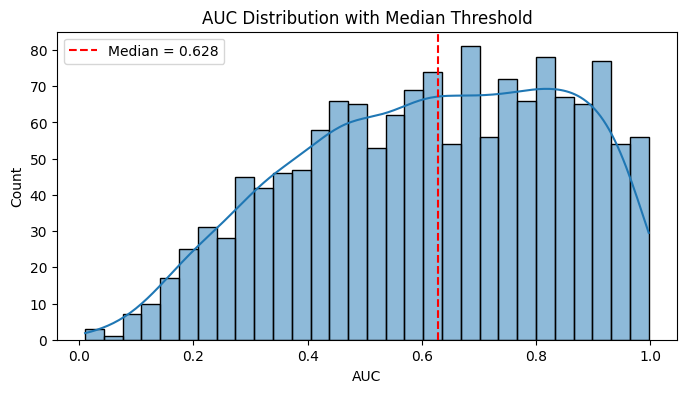


Threshold = 0.63 ➔ Class balance:
label_0.627956
0    0.500339
1    0.499661
Name: proportion, dtype: float64


Threshold = 0.30 ➔ Class balance:
label_0.3
0    0.891525
1    0.108475
Name: proportion, dtype: float64


Threshold = 0.50 ➔ Class balance:
label_0.5
0    0.672542
1    0.327458
Name: proportion, dtype: float64


Threshold = 0.70 ➔ Class balance:
label_0.7
1    0.598644
0    0.401356
Name: proportion, dtype: float64



In [14]:
# Objectif 4 : Classification
# 1. Copy df_training to start your classification dataset
df_classification = df_training.copy()

# 2. Choose the “median” threshold so that AUC is split 50/50
threshold_median = df_classification['AUC'].median()

# 3. (Optional) Inspect the AUC distribution & chosen threshold
plt.figure(figsize=(8,4))
sns.histplot(df_classification['AUC'], bins=30, kde=True)
plt.axvline(threshold_median, color='red', linestyle='--',
            label=f'Median = {threshold_median:.3f}')
plt.title('AUC Distribution with Median Threshold')
plt.xlabel('AUC')
plt.legend()
plt.show()

# 4. Define thresholds to compare
thresholds = [threshold_median, 0.3, 0.5, 0.7]

# 5. Storage for all results
results = []

# 6. Loop over each threshold
for thr in thresholds:
    # 6a. Create binary label: sensitive = 1 if AUC < thr, else resistant = 0
    col_name = f'label_{thr}'
    df_classification[col_name] = (df_classification['AUC'] < thr).astype(int)
    
    # 6b. Show class balance
    balance = df_classification[col_name].value_counts(normalize=True)
    print(f'\nThreshold = {thr:.2f} ➔ Class balance:\n{balance}\n')
    
    # 6c. Define X (features) and y (binary target)
    feature_cols = (
        list(df_classification.loc[:, 'MT-CO2':'DRUG_1386'].columns)
        + ['MIN_CONC', 'MAX_CONC']
    )
    X = df_classification[feature_cols]
    y = df_classification[col_name]
    
    # 6d. Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 6e. Split (stratify to preserve class ratios)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 6f. Define classifiers
    models = {
        'RandomForest': RandomForestClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'XGBoost': XGBClassifier(
            use_label_encoder=False, eval_metric='logloss', random_state=42
        )
    }
    
    # 6g. Train & evaluate each
    for name, clf in models.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]
        
        results.append({
            'threshold':       thr,
            'model':           name,
            'accuracy':        accuracy_score(y_test, y_pred),
            'f1_score':        f1_score(y_test, y_pred),
            'roc_auc':         roc_auc_score(y_test, y_prob),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        })

# 7. Compile performance across all thresholds & models
df_results = pd.DataFrame(results)

In [15]:
df_results

,threshold,model,accuracy,f1_score,roc_auc,confusion_matrix
0,0.627956,RandomForest,0.755932,0.753425,0.842963,"[[113, 35], [37, 110]]"
1,0.627956,SVM,0.708475,0.709459,0.798584,"[[104, 44], [42, 105]]"
2,0.627956,XGBoost,0.749153,0.746575,0.825749,"[[112, 36], [38, 109]]"
3,0.300000,RandomForest,0.894915,0.114286,0.852246,"[[262, 1], [30, 2]]"
4,0.300000,SVM,0.891525,0.000000,0.842205,"[[263, 0], [32, 0]]"
5,0.300000,XGBoost,0.905085,0.363636,0.830086,"[[259, 4], [24, 8]]"
6,0.500000,RandomForest,0.789831,0.643678,0.859575,"[[177, 21], [41, 56]]"
7,0.500000,SVM,0.718644,0.496970,0.797017,"[[171, 27], [56, 41]]"
8,0.500000,XGBoost,0.772881,0.625698,0.856347,"[[172, 26], [41, 56]]"
9,0.700000,RandomForest,0.779661,0.823848,0.866585,"[[78, 40], [25, 152]]"


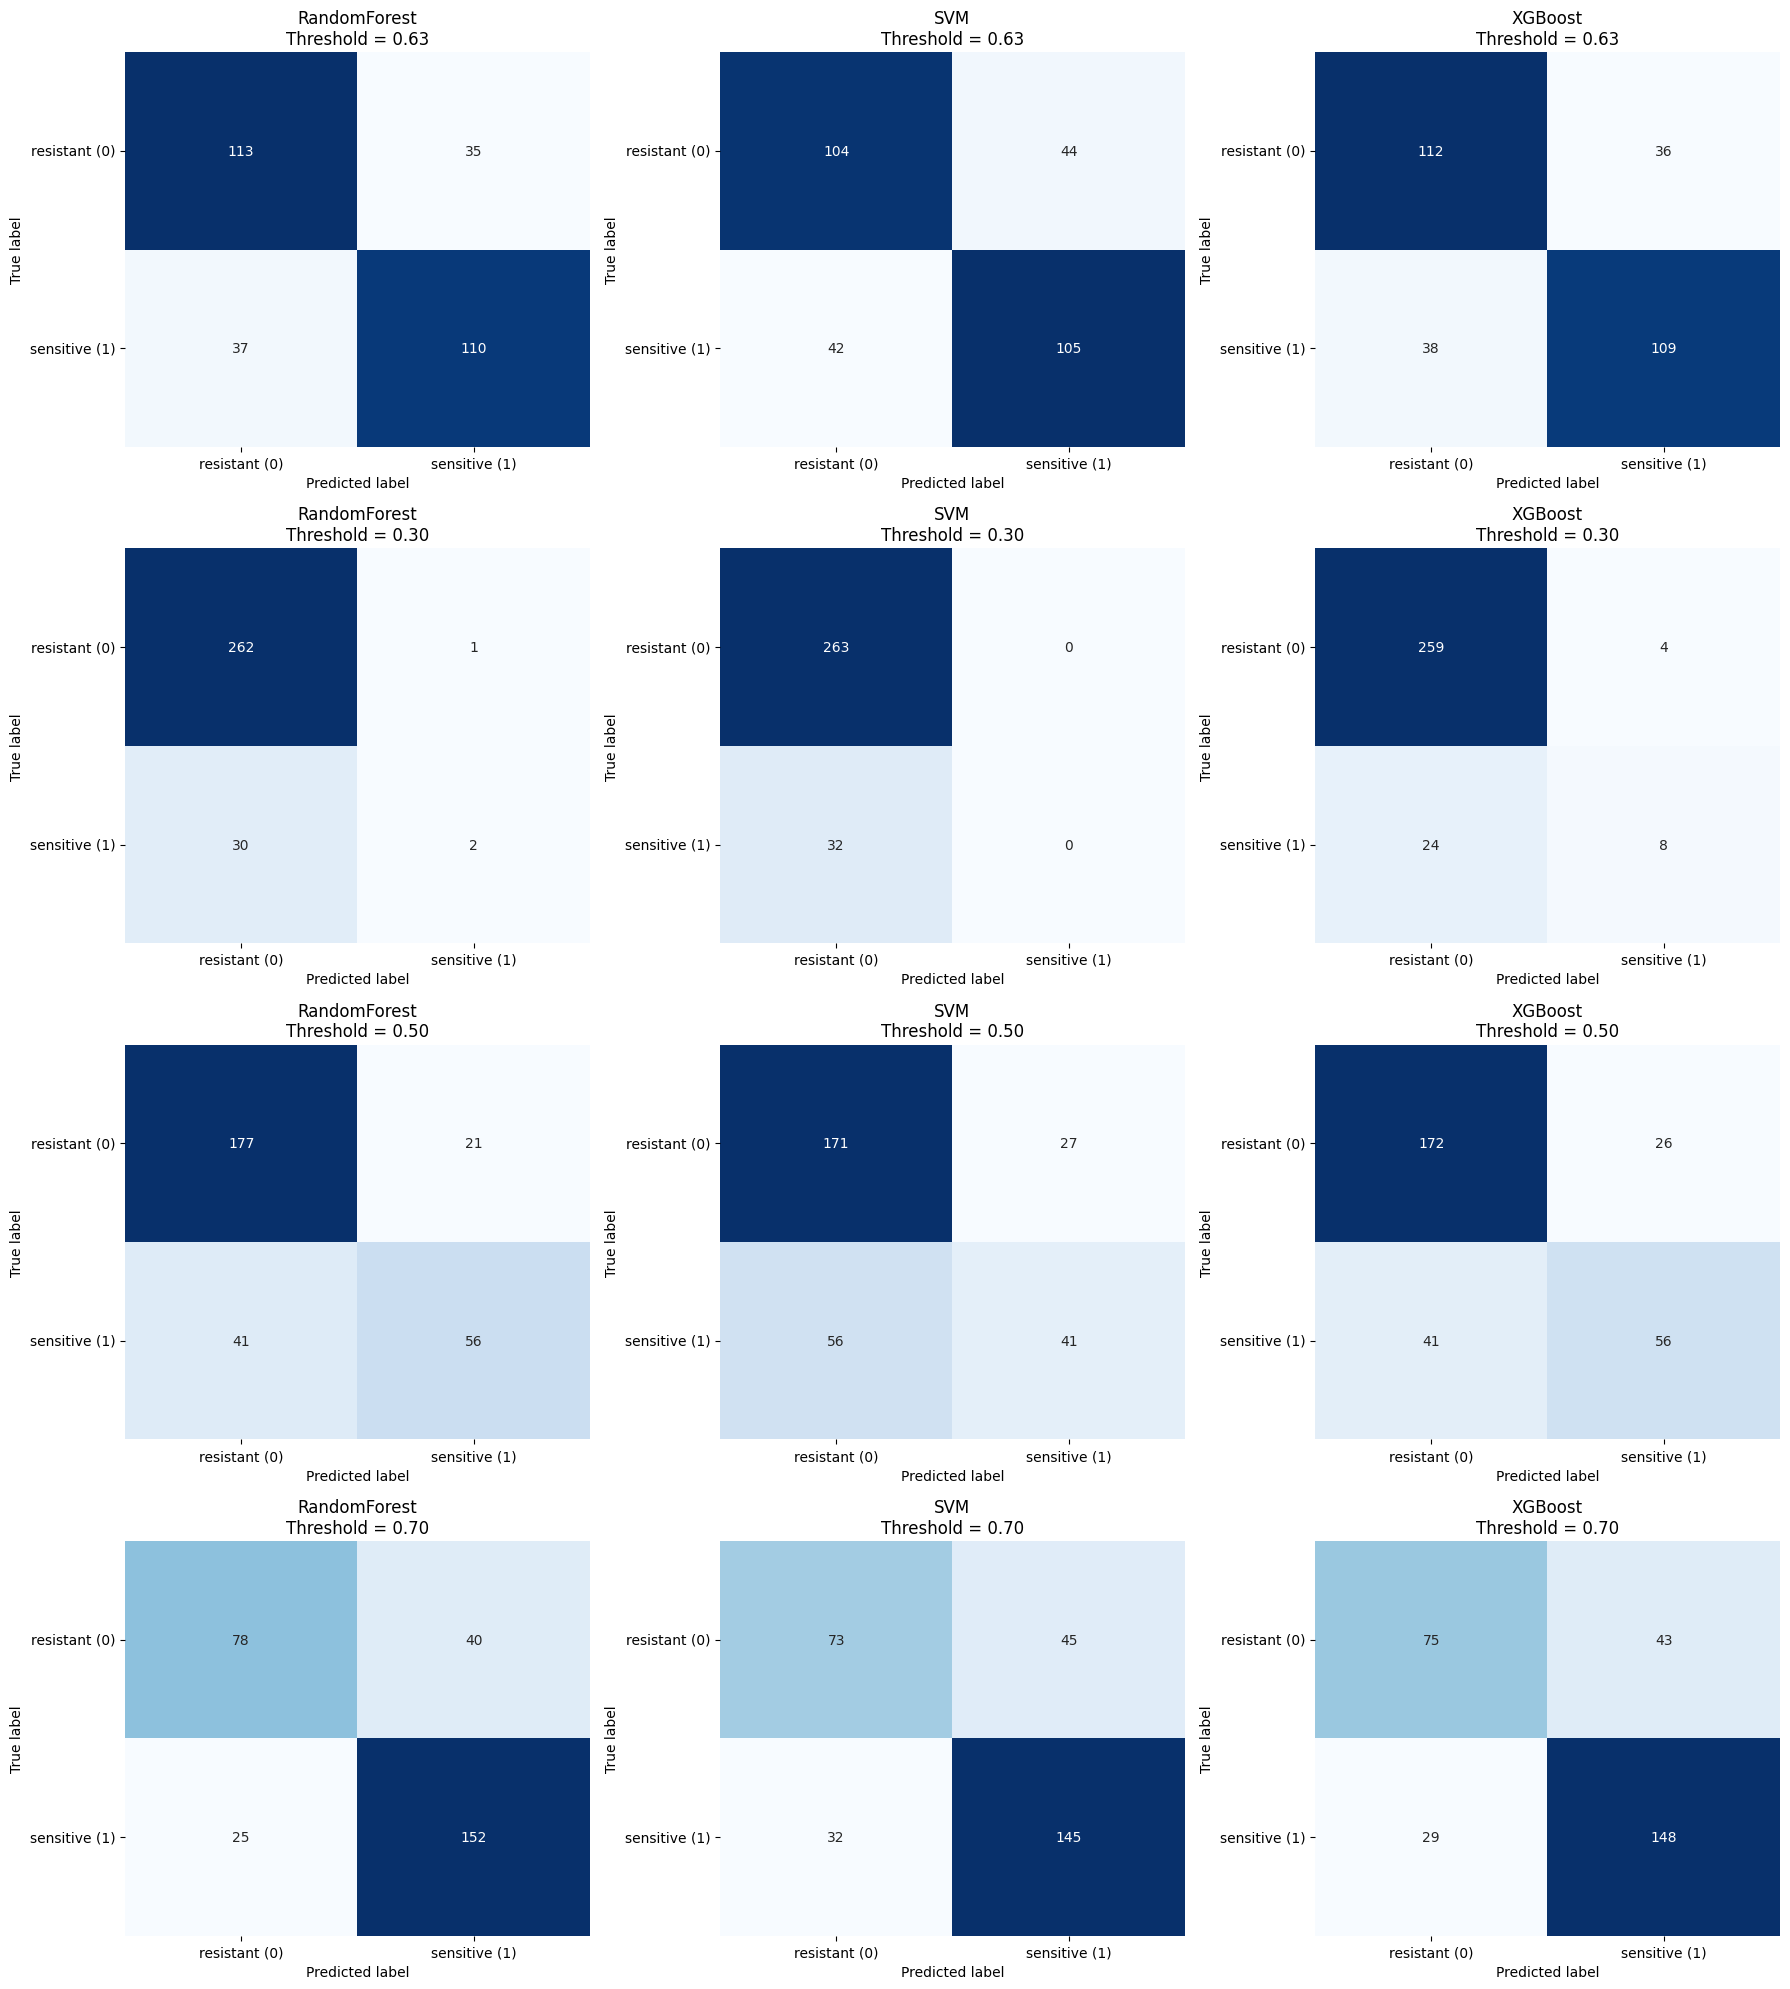

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Définir 3 matrices par ligne
n = len(df_results)
ncols = 3
nrows = (n + ncols - 1) // ncols  # arrondi supérieur

plt.figure(figsize=(6 * ncols, 5 * nrows))  # ajuste la taille globale de la figure

for i, (_, row) in enumerate(df_results.iterrows(), start=1):
    cm = row['confusion_matrix']
    thr = row['threshold']
    model = row['model']
    
    ax = plt.subplot(nrows, ncols, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_xticklabels(['resistant (0)', 'sensitive (1)'])
    ax.set_yticklabels(['resistant (0)', 'sensitive (1)'], rotation=0)
    ax.set_title(f"{model}\nThreshold = {thr:.2f}")

plt.tight_layout()
plt.show()



Top 10 features for Doxorubicin (ID: 133):
NPM1       0.010136
MT-RNR1    0.009891
TUBB       0.009885
CCN1       0.009885
PFN1       0.009477
TMSB10     0.009469
PSAP       0.009297
LYZ        0.009277
MT-ND3     0.008993
FTL        0.008992
dtype: float64


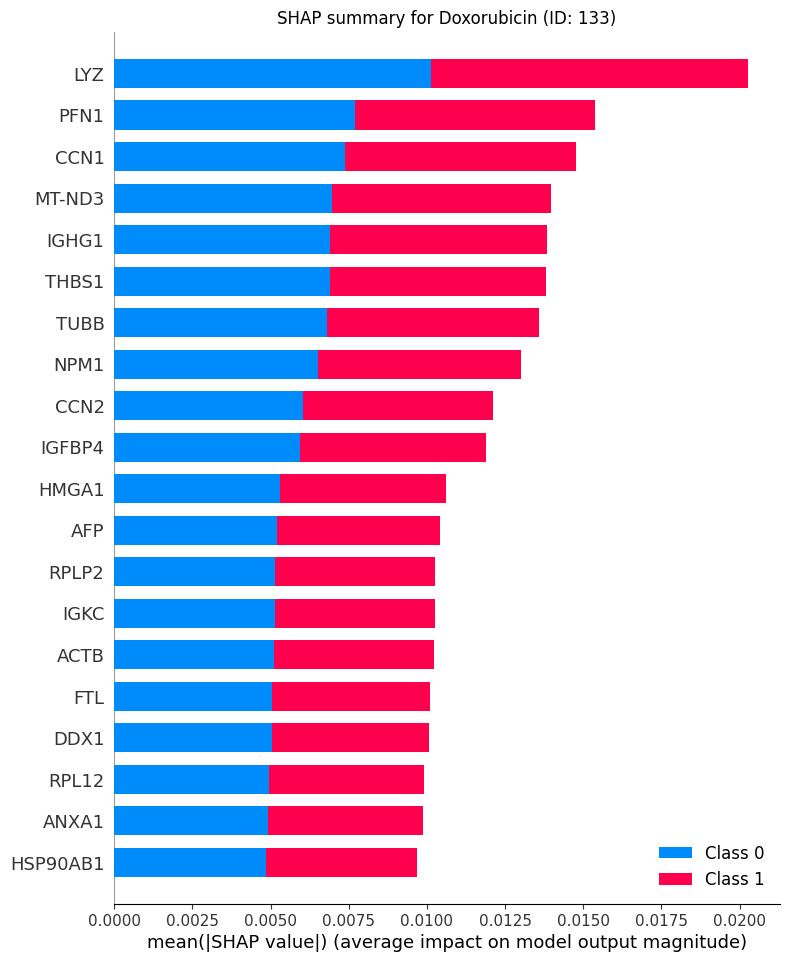

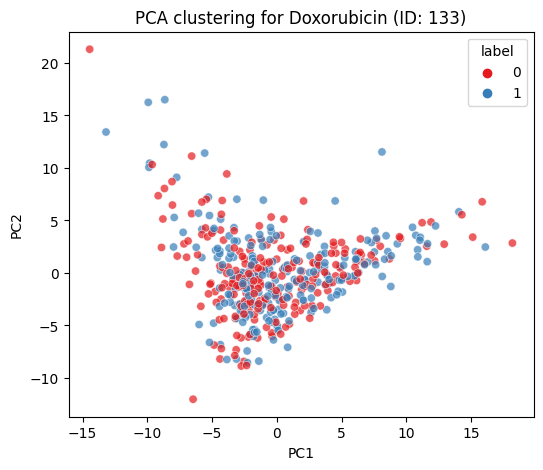

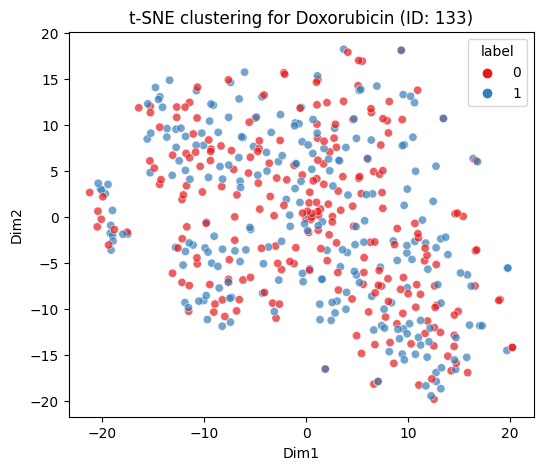


Top 10 features for Docetaxel (ID: 1007):
ANXA1     0.025670
CCN1      0.014649
CCN2      0.014344
HSPA5     0.014252
CAV1      0.013044
ENO1      0.011868
TXN       0.011846
MT2A      0.011535
LGALS1    0.011178
NQO1      0.010509
dtype: float64


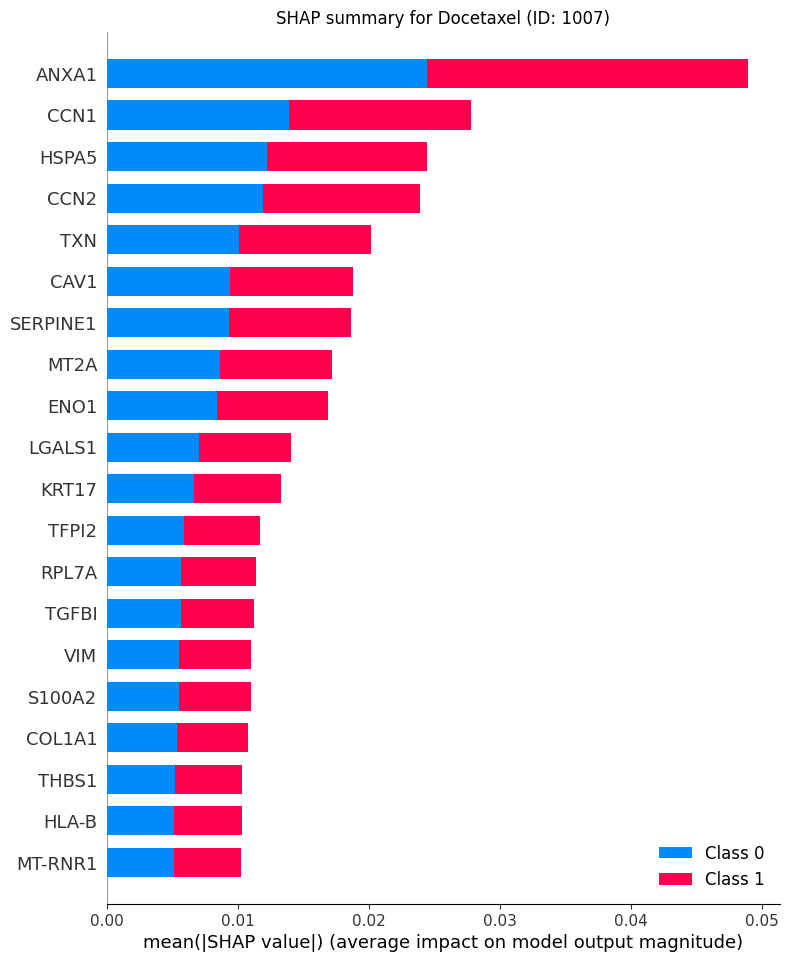

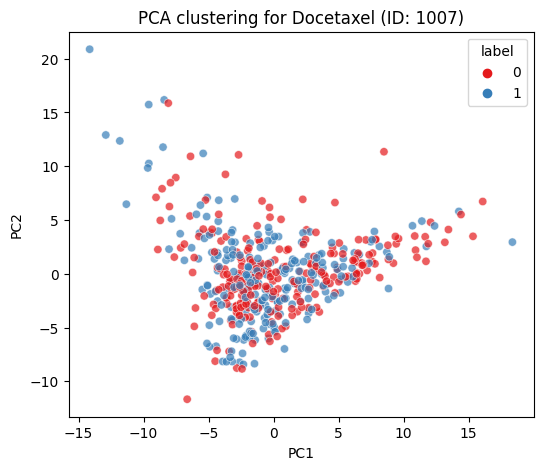

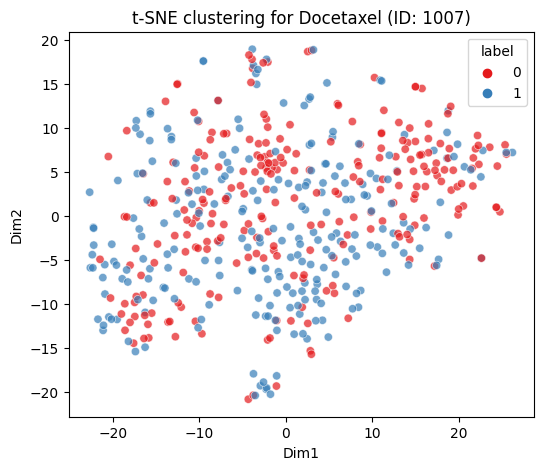


Top 10 features for Doxorubicin (ID: 1386):
MT-RNR1    0.016200
RPL12      0.015872
PFN1       0.015537
ENO1       0.013843
MT-ND6     0.013522
VIM        0.012969
AGR2       0.012923
ANXA1      0.012425
CEACAM6    0.012138
MT-TC      0.011116
dtype: float64


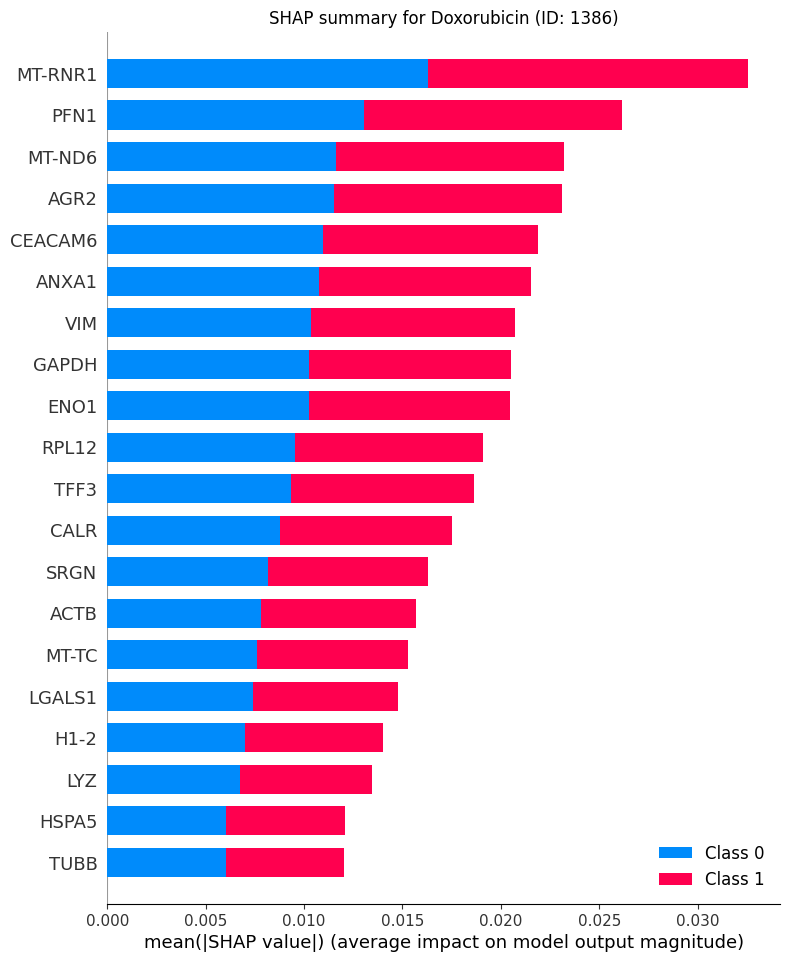

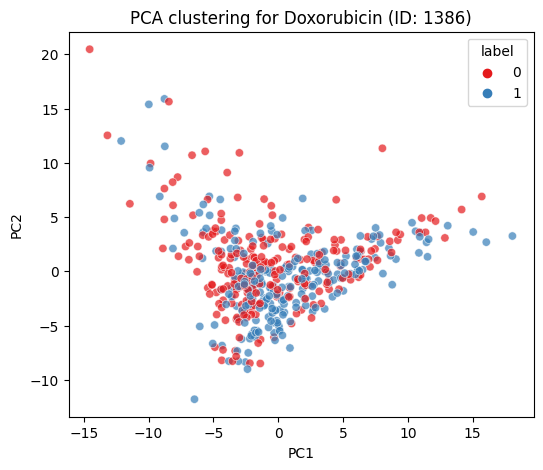

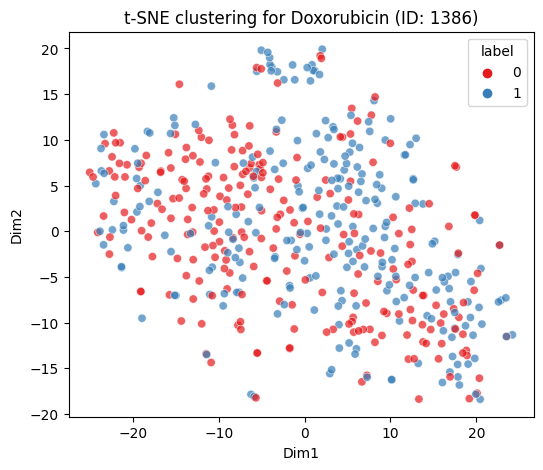

In [16]:
# assume df_classification already exists and includes all features + AUC
feature_cols = list(df_classification.loc[:, 'MT-CO2':'DRUG_1386'].columns) + ['MIN_CONC', 'MAX_CONC']

# loop over each drug
unique_drugs = df_classification[['DRUG_ID','DRUG_NAME']].drop_duplicates()
for _, row in unique_drugs.iterrows():
    drug_id   = row['DRUG_ID']
    drug_name = row['DRUG_NAME']
    
    # subset per drug
    df_drug = df_classification[df_classification['DRUG_ID'] == drug_id].copy()
    
    # 1) threshold = median AUC for this drug
    thr = df_drug['AUC'].median()
    df_drug['label'] = (df_drug['AUC'] < thr).astype(int)
    
    X = df_drug[feature_cols]
    y = df_drug['label']
    
    # normalize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # --- Feature importance via Random Forest ---
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_scaled, y)
    importances = pd.Series(rf.feature_importances_, index=feature_cols)
    importances = importances.sort_values(ascending=False)
    print(f"\nTop 10 features for {drug_name} (ID: {drug_id}):")
    print(importances.head(10))
    
    # --- SHAP summary plot ---
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_scaled)
    plt.figure(figsize=(8,6))
    shap.summary_plot(shap_values, X, show=False)
    plt.title(f"SHAP summary for {drug_name} (ID: {drug_id})")
    plt.show()
    
    # --- PCA visualization ---
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    df_pca = pd.DataFrame(X_pca, columns=['PC1','PC2'])
    df_pca['label'] = y.values
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', palette='Set1', alpha=0.7)
    plt.title(f"PCA clustering for {drug_name} (ID: {drug_id})")
    plt.show()
    
    # --- t-SNE visualization ---
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    df_tsne = pd.DataFrame(X_tsne, columns=['Dim1','Dim2'])
    df_tsne['label'] = y.values
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df_tsne, x='Dim1', y='Dim2', hue='label', palette='Set1', alpha=0.7)
    plt.title(f"t-SNE clustering for {drug_name} (ID: {drug_id})")
    plt.show()